# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 140000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (140000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(118907, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

84.93357142857143

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

Observation(s):

1. I have keep only those values whose HelpfulnessNumerator <= HelpfulnessDenominator.

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(118905, 10)


1    99869
0    19036
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_118904 = final['Text'].values[118904]
print(sent_118904)
print("="*50)

Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.
I love chai tea and this is definitely reminiscent of that. It's got a wonderful aroma and tastes good hot or cold. I'm definitely buying it again. It also reminds me of special home-made tea I had at a NYC Indian restaurant which was fabulous. Excellent tea. Well worth the price!
Purchased this product at a local store in NY and my kids and i love it. Its a quick easy meal. You can put in a toaster oven on toast for 6 min. and its ready to eat.<br />strongly recommend


In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_118904 = re.sub(r"http\S+", "", sent_118904)

print(sent_0)

Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_118904, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.
I love chai tea and this is definitely reminiscent of that. It's got a wonderful aroma and tastes good hot or cold. I'm definitely buying it again. It also reminds me of special home-made tea I had at a NYC Indian restaurant which was fabulous. Excellent tea. Well worth the price!
Purchased this product at a local store in NY and my kids and i love it. Its a quick easy meal. You can put in a toaster oven on toast for 6 min. and its ready to eat.strongly recommend


In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_118904 = decontracted(sent_118904)
print(sent_118904)
print("="*50)

Purchased this product at a local store in NY and my kids and i love it. Its a quick easy meal. You can put in a toaster oven on toast for 6 min. and its ready to eat.<br />strongly recommend


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_118904 = re.sub('[^A-Za-z0-9]+', ' ', sent_118904)
print(sent_118904)

Purchased this product at a local store in NY and my kids and i love it Its a quick easy meal You can put in a toaster oven on toast for 6 min and its ready to eat br strongly recommend


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

Observation(s):

1. Here we are having set of stopwords.
2. Here so many unused word in the stopwords.
3. stopwords are words which contain a dictionary of unused words.
4. If we are removing stopwordsthen our Bag of Words is much smaller and meaningful vector.

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 118905/118905 [01:17<00:00, 1527.76it/s]


In [23]:
preprocessed_reviews[118904]

'purchased product local store ny kids love quick easy meal put toaster oven toast min ready eat strongly recommend'

In [24]:
#adding a column of CleanedText which displays the data after pre-processing of the review
final['CleanedText']=preprocessed_reviews
final['CleanedText']=final['CleanedText']
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (118905, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138687,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,1,1210809600,A classic,Get the movie or sound track and sing along wi...,get movie sound track sing along carol king gr...
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,0,1129507200,awesome book poor size,This is one of the best children's books ever ...,one best children books ever written mini vers...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,1,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",daughter loves really rosie books introduced r...
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138705,150523,0006641040,A2P4F2UO0UMP8C,"Elizabeth A. Curry ""Lovely Librarian""",0,0,1,1096675200,MMMM chicken soup....,Summary: A young boy describes the usefulness...,summary young boy describes usefulness chicken...


Observation(s):

1. Here processed review can be seen in the CleanedText Column.
2. We will use it for future observation.
3. we are having 118905 matrix of features.

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [25]:
# printing some random reviews
sent_0 = final['Summary'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Summary'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Summary'].values[1500]
print(sent_1500)
print("="*50)

sent_118904 = final['Summary'].values[118904]
print(sent_118904)
print("="*50)

A classic
Wonderfully soothing tea
Awesome underlooked seasoning!
DELICIOUS


In [26]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_118904 = re.sub(r"http\S+", "", sent_118904)

print(sent_0)

A classic


In [27]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_118904, 'lxml')
text = soup.get_text()
print(text)

A classic
Wonderfully soothing tea
Awesome underlooked seasoning!
DELICIOUS


In [28]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [29]:
sent_118904 = decontracted(sent_118904)
print(sent_118904)
print("="*50)

DELICIOUS


In [30]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

A classic


In [31]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_118904 = re.sub('[^A-Za-z0-9]+', ' ', sent_118904)
print(sent_118904)

DELICIOUS


In [32]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [33]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_Summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 118905/118905 [00:55<00:00, 2161.17it/s]


In [34]:
preprocessed_Summary = [118904]
print (preprocessed_Summary)

[118904]


# Time Based Splitting

In [35]:
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# Randomly selecting 20K datapoints

# We will collect different 20K rows without repetition from time_sorted_data dataframe
final_20 = time_sorted_data.take(np.random.permutation(len(final))[:100000])
print(final_20.shape)
final_20.head(3)

(100000, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
89821,97745,B0050MMKBA,A380L2XG1YHPF2,loveee,0,0,1,1349308800,I love Celsius but...,"I love Celsius. Granted, I've failed to contin...",love celsius granted failed continue workout r...
49656,53924,B004CSUGP0,A3K975P8HB7VZI,D. Cochems,23,24,1,1291939200,may cause drowsiness?!,"""Draught of the Living Death"" would be a bette...",draught living death would better name freakin...
35212,38294,B007R1PGVS,A1KB18RBNOPZD5,G. J. Burk,2,2,1,1208131200,Great for keeping you on the go!,"Zipfizz, Tastes good and keeps you moving all ...",zipfizz tastes good keeps moving day zipfizz l...


Observation(s):
1. Time based splitting is better than random splitting.
2. In time based splitting we sort our data in ascending order.
3. In TIme based splitting we get better accuracy than random splitting.

In [36]:
# sample dataset 
final_20['Score'].value_counts()

1    83932
0    16068
Name: Score, dtype: int64

In [37]:
# Original dataset
final['Score'].value_counts()

1    99869
0    19036
Name: Score, dtype: int64

In [38]:
# Ratio of positive reviews to negative reviews in Sample Dataset
len(final_20[final_20['Score'] == 1])/len(final_20[final_20['Score'] == 0])

5.223549912870301

In [39]:
# Ratio of positive reviews to negative reviews in Original Dataset
len(final[final['Score'] == 1])/len(final[final['Score'] == 0])

5.246322756881698

In [40]:
# final_20 datapoints which will use to train model
X = final_20['CleanedText'].values
print("shape of X:", X.shape)

shape of X: (100000,)


In [41]:
# class label
y = final_20['Score'].values
print("shape of y:", y.shape)

shape of y: (100000,)


In [42]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# Splitting the data set into training set and test set:
from sklearn.model_selection import train_test_split

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, test_size=0.33)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, X_cv.shape, Y_cv.shape)

(53600,) (53600,) (20000,) (20000,) (26400,) (26400,)


Observation(s):
    
1. I have split the dataset into training set and testing set.
2. Here 80% of the data used to train the model and 20% of the data used to test its performance of the test set.
3. Here i have 53600 points to train the model and 20000 points to test its performance on the test set.

# [4] Featurization

## [4.1] BAG OF WORDS

In [43]:
#BoW
#https://www.kaggle.com/rochachan/part-1-for-beginners-bag-of-words
from sklearn.feature_extraction.text import CountVectorizer    #in scikit-learn
count_vect = CountVectorizer(min_df = 20, max_features=500).fit(X_train) # Here I am fitting my CountVectorizer function  into X_train and Then transform into X_train and X_test. 
# we also use fit_transform method for training set. I am doind it for auc
# min_df = 20;min_df = 20, which will remove any words from our vocabulary that appear in fewer than five documents.
# https://towardsdatascience.com/scikit-learn-for-text-analysis-of-amazon-fine-food-reviews-ea3b232c2c1b
X_train_bow = count_vect.transform(X_train)
X_cv_bow = count_vect.transform(X_cv)
X_test_bow = count_vect.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, Y_train.shape)
print(X_cv_bow.shape, Y_cv.shape)
print(X_test_bow.shape, Y_test.shape)
print("="*100)

print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)
print("the type of count vectorizer :",type(X_train_bow))
print("the shape of out text BOW vectorizer : ",X_train_bow.get_shape())
print("the number of unique words :", X_train_bow.get_shape()[1])

After vectorizations
(53600, 500) (53600,)
(26400, 500) (26400,)
(20000, 500) (20000,)
some feature names  ['able', 'absolutely', 'actually', 'add', 'added', 'adding', 'aftertaste', 'ago', 'almost', 'already']
the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (53600, 500)
the number of unique words : 500


## [4.2] Bi-Grams and n-Grams.

In [44]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=20, max_features=500).fit(X_train)
X_train_bow = count_vect.transform(X_train)
X_cv_bow = count_vect.transform(X_cv)
X_test_bow = count_vect.transform(X_test)
print("the type of count vectorizer ",type(X_train_bow))
print("the shape of out text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_bow.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (53600, 500)
the number of unique words including both unigrams and bigrams  500


## [4.3] TF-IDF

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(min_df=50, max_features=500).fit(X_train)
X_train_tf_idf = tf_idf_vect.transform(X_train)
X_cv_tf_idf = tf_idf_vect.transform(X_cv)
X_test_tf_idf = tf_idf_vect.transform(X_test)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)
print("the type of count vectorizer :",type(X_train_tf_idf))
print("the shape of out text TFIDF vectorizer : ",X_train_tf_idf.get_shape())
print("the number of unique words :", X_train_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'adding', 'aftertaste', 'ago', 'almost', 'already']
the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (53600, 500)
the number of unique words : 500


In [46]:
print("the number of unique words :", X_test_tf_idf.get_shape()[1])

the number of unique words : 500


## [4.4] Word2Vec

## Preparing Reviews for gensim model

In [47]:
# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

## Training w2v model

In [48]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [49]:
# Train our own Word2Vec model using our own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))
print('='*70)

[('awesome', 0.8184800148010254), ('fantastic', 0.8152948021888733), ('good', 0.8040257096290588), ('excellent', 0.8034015893936157), ('wonderful', 0.7914230227470398), ('terrific', 0.7521377801895142), ('amazing', 0.7459107041358948), ('perfect', 0.7131716012954712), ('fabulous', 0.7026510238647461), ('nice', 0.6845498085021973)]
[('nastiest', 0.7617213129997253), ('greatest', 0.74774569272995), ('best', 0.7236289978027344), ('tastiest', 0.7065700888633728), ('coolest', 0.6955728530883789), ('shiniest', 0.6623662710189819), ('disgusting', 0.6483449935913086), ('vile', 0.6446125507354736), ('superior', 0.6229807138442993), ('closest', 0.6214763522148132)]


In [50]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  13970
sample words  ['tea', 'light', 'taste', 'drink', 'day', 'months', 'hoping', 'better', 'hair', 'nails', 'seeing', 'dr', 'oz', 'far', 'not', 'seen', 'result', 'yet', 'hopeful', 'iced', 'black', 'lemon', 'ingredient', 'list', 'order', 'honey', 'granules', 'sugar', 'citric', 'acid', 'powder', 'green', 'maltodextrin', 'corn', 'caramel', 'color', 'contains', 'sulfites', 'sucralose', 'sweetener', 'natural', 'flavor', 'hibiscus', 'extract', 'often', 'msg', 'good', 'packet', 'makes', 'cal']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

## Algorithm: Avg W2V

#### [4.4.1.1] Avg W2v

In [51]:
from tqdm import tqdm
import numpy as np

### Converting Train data text

In [52]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|███████████████████████████████████████████████████████████████████████████| 53600/53600 [02:25<00:00, 369.36it/s]


(53600, 50)
[-0.07805932  0.47755356 -0.11770195  0.244728   -0.21219521 -0.56756045
 -0.42497303 -0.51717696  0.47935528  0.21061383 -0.39447316 -0.79755545
 -0.13328687  0.47218161  0.78931719  0.26204122  0.78378007 -0.24086548
 -0.09386013  0.12416599 -0.13106791 -0.27889676 -0.69388416 -0.67953374
  0.45406572  0.12068276  0.41389126 -0.56399161  0.50234147 -0.53764398
  0.59528314 -0.08753023 -0.03129011 -0.45517343  0.66411277  0.09336918
  0.2747293  -0.02931445 -0.03302492 -0.68102666 -0.42085125 -0.0651276
  0.3110463  -0.36254063 -0.44663025  0.37134652  0.21325629 -0.76930595
 -0.35425462 -0.15475223]


### Converting CV data text

In [53]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [54]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|███████████████████████████████████████████████████████████████████████████| 26400/26400 [01:15<00:00, 351.15it/s]

(26400, 50)
[ 0.42851292 -0.24987446  0.32121925 -0.21945436  0.94471994 -0.49115809
 -0.57751767 -0.37626293  0.00858736  0.13945841 -0.95937182 -0.653188
 -0.2817377   0.31078546  0.01543624  0.26844095 -0.59034707 -1.22115866
 -0.25811245 -0.65008991 -0.42960592 -0.15440158 -0.43249823 -0.22744103
  0.09767644 -0.1204765   0.37074263 -0.34154877  0.12034571 -0.50658786
 -0.10737106 -0.81256004 -0.59312037 -0.29503543  0.07338045  0.31377546
  0.34992299 -0.05213966 -0.5811931  -1.07870902 -0.52046578 -0.06043134
  0.88061551  0.08248886 -0.39683917  0.18704845 -0.16609139 -1.04397479
 -0.64533634 -0.02989938]


### Converting Test data text

In [55]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [56]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:59<00:00, 338.63it/s]

(20000, 50)
[-0.37849068  0.00344394  0.30673406  0.40802446  0.57626596 -0.64298092
 -0.88831909 -0.28042542 -0.21822413  0.63654415 -0.67199867 -0.60244573
  0.4301627   0.07672256  0.00896475  0.68804544 -0.06628257 -0.31022661
 -0.52514492 -0.22216007  0.39954336  0.02250126 -0.58841213 -1.06275149
  0.23667206 -0.15608487 -0.2241279  -0.12610346  0.24996624 -0.48282569
  1.04065236 -0.39106624 -0.81931971  0.26108772 -0.29914213  0.23358087
 -0.2879098  -0.20166582 -0.12235782 -0.75640063  0.04075178  0.37251598
  0.08995371 -0.07072186 -0.7360268  -0.05143121  0.0135327  -0.53729491
 -0.27656736 -0.77277123]


#### [4.4.1.2] TFIDF weighted W2v

In [57]:
from tqdm import tqdm
import numpy as np

In [58]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

### Converting Train data text

In [59]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_fealist_of_sentance_traint.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)
print(tfidf_sent_vectors_train.shape)
print(tfidf_sent_vectors_train[0])

100%|██████████████████████████████████████████████████████████████████████████| 53600/53600 [1:01:38<00:00, 14.49it/s]

(53600, 50)
[-0.01257983  0.37366814 -0.14760241  0.18924633 -0.25476784 -0.26909407
 -0.28045594 -0.51057699  0.5060812   0.14520956 -0.31341662 -0.77648049
 -0.10510539  0.54337427  0.58637666  0.16633423  0.6513899  -0.11383174
 -0.06711557  0.16220687 -0.11091655 -0.23346462 -0.48039268 -0.51275796
  0.35539507  0.05335038  0.38455871 -0.58081606  0.66577247 -0.34814429
  0.50753146  0.02415638 -0.02569625 -0.417449    0.66586604  0.0574217
  0.19297951 -0.06040902 -0.04131262 -0.55662524 -0.36008107  0.00293491
  0.18091931 -0.39587013 -0.32645059  0.22306737  0.21454024 -0.59517305
 -0.33942783 -0.29440971]


In [60]:
print(len(tfidf_sent_vectors_train))
print(len(tfidf_sent_vectors_train[0]))

53600
50


### Converting CV data text

In [61]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [62]:
tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_fealist_of_sentance_traint.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1
tfidf_sent_vectors_cv = np.array(tfidf_sent_vectors_cv)
print(tfidf_sent_vectors_cv.shape)
print(tfidf_sent_vectors_cv[0])

100%|████████████████████████████████████████████████████████████████████████████| 26400/26400 [30:46<00:00, 14.29it/s]

(26400, 50)
[ 0.3981543  -0.16987521  0.32163279 -0.21433953  0.89253244 -0.39461
 -0.50305263 -0.33042001 -0.0198646   0.0938447  -0.85735958 -0.71893884
 -0.24424258  0.29214234  0.03937187  0.16697297 -0.51083528 -1.04844599
 -0.17497775 -0.60682471 -0.4120708  -0.10060473 -0.27128345 -0.10288378
  0.01683209 -0.21784887  0.34262444 -0.27844995  0.18508651 -0.39062905
 -0.09350478 -0.57399348 -0.61736524 -0.32684134  0.15055361  0.1620571
  0.31117591 -0.12792363 -0.516513   -1.00811667 -0.47090527 -0.03643597
  0.66534891 -0.06279235 -0.39714061  0.23651813 -0.16051635 -0.90519987
 -0.52557089 -0.07014003]


### Converting Test data text

In [63]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [64]:
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_fealist_of_sentance_traint.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)
print(tfidf_sent_vectors_test.shape)
print(tfidf_sent_vectors_test[0])

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [22:22<00:00, 14.90it/s]

(20000, 50)
[-0.30293479  0.08421475  0.24413945  0.3685348   0.57611457 -0.50744476
 -0.75767887 -0.47912683 -0.18400153  0.58706112 -0.63802553 -0.71283678
  0.57128353  0.09918965  0.07198279  0.65714623 -0.03269008 -0.33409398
 -0.47995286 -0.20278421  0.42094032 -0.02344986 -0.59293843 -1.12068844
  0.21557737 -0.1908611  -0.16019298 -0.12804294  0.18949062 -0.41204841
  1.15676135 -0.34534875 -0.89649616  0.22555228 -0.24707328  0.12140853
 -0.35469842 -0.15320136 -0.033764   -0.72489159  0.07866662  0.41597909
 -0.02973093 -0.16259038 -0.65670084 -0.01907721 -0.01877208 -0.42860898
 -0.11945095 -0.85620971]


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [65]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_bow_standardized = sc.fit_transform(X_train_bow)
X_test_bow_standardized = sc.transform(X_test_bow)
X_cv_bow_standardized = sc.transform(X_cv_bow)

In [66]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'roc_auc', cv=3 ,n_jobs=-1, 
                     pre_dispatch=2)
model.fit(X_cv_bow_standardized, Y_cv)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_cv_bow_standardized, Y_cv))


optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

C:\Users\dell\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\dell\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Model with best parameters :
 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.9155019108263468
The optimal value of C(1/lambda) is :  1


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter

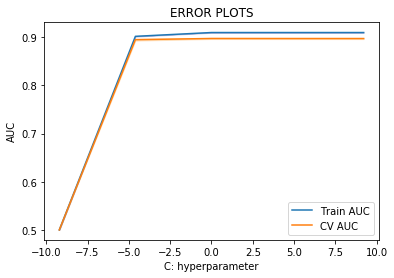

In [67]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
C = [10**-4, 10**-2, 10**0, 10**2, 10**4]
for i in C:

    lr = LogisticRegression(penalty='l1', C = i)
    tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
    clf = GridSearchCV(lr, tuned_parameters, cv=3, scoring='roc_auc')
    clf.fit(X_train_bow_standardized, Y_train)
    

    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(np.log(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Testing with Test data

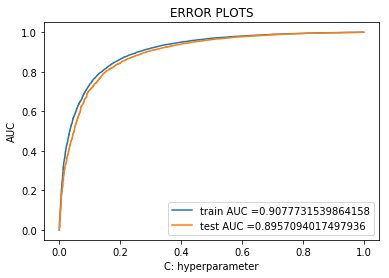

Train confusion matrix
[[ 4296  4356]
 [ 1360 43588]]
Test confusion matrix
[[ 1514  1654]
 [  567 16265]]
Test AUC is: 0.8957094017497936


In [68]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


lr = LogisticRegression(C=1) # Here in plce of n_neighbors=19 we can also take n_neighbors=optimal_k. optimal_k will 
                                           # automatically take value which we have been observed when we have done 
                                           # k-fold cross validation
lr.fit(X_train_bow_standardized, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, lr.predict_proba(X_train_bow_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, lr.predict_proba(X_test_bow_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, lr.predict(X_train_bow_standardized)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, lr.predict(X_test_bow_standardized)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
bow_L1_auc = roc_auc_score(Y_test, lr.predict_proba(X_test_bow_standardized)[:,1])
print("Test AUC is:", bow_L1_auc)

In [69]:
# http://localhost:8888/notebooks/Downloads/kfold.ipynb
# ============================== lr with k = optimal_k ===============================================
# instantiate learning model k = optimal_k

lr_optimal = LogisticRegression(C=optimal_C)

# fitting the model
lr_optimal.fit(X_train_bow_standardized, Y_train)

# predict the response
Y_pred = lr_optimal.predict(X_test_bow_standardized)

# Accuracy on test data
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
bow_L1_grid_C = optimal_C
bow_L1_grid_train_acc = model.score(X_test_bow_standardized, Y_test)*100
bow_L1_grid_test_acc = acc


The Test Accuracy of the Logistic Regression classifier for C = 1.000 is 88.895000%


Observation(s):
    
1. The Test Accuracy of the Logistic Regression classifier for C = 0.100 is 88.675%.

# Confusion Matrix of Training Set Of BOW Model

In [70]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_train, lr.predict(X_train_bow_standardized))
cm

array([[ 4296,  4356],
       [ 1360, 43588]], dtype=int64)

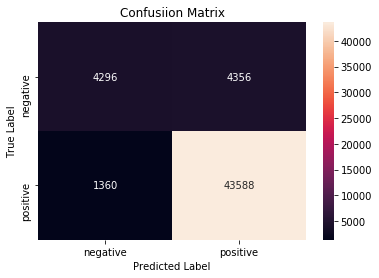

In [71]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Training Set Of BOW Model.
1. As we have seen on confusion matrix, we have 43668 + 4222 = 47890 correct prediction on training set.
2. Acccuracy of 47890 correct prediction on training set is 89.347%.

# Confusion Matrix For Test Set Of BOW Model

In [72]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_test, lr.predict(X_test_bow_standardized)))
cm

array([[ 1514,  1654],
       [  567, 16265]], dtype=int64)

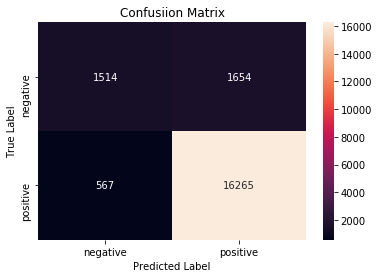

In [73]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Test Set Of BOW Model.
2. As we have seen on confusion matrix, we have 16179 + 1556 = 17735 correct prediction on test set.
2. Acccuracy of 17735 correct prediction on test set is 88.675%.

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

# sparsity on weight vector obtained after using L1 regularization

In [74]:
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C)

# With lambda = 1
clf = LogisticRegression(C=1, penalty='l1',n_jobs=-1);
clf.fit(X_train_bow_standardized, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

500


In [75]:
# With lambda = 10
clf = LogisticRegression(C=0.1, penalty='l1',n_jobs=-1);
clf.fit(X_train_bow_standardized, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

483


In [76]:
# With lambda = 100
clf = LogisticRegression(C=0.01, penalty='l1',n_jobs=-1);
clf.fit(X_train_bow_standardized, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

317


In [77]:
# With lambda = 1000
clf = LogisticRegression(C=0.001, penalty='l1',n_jobs=-1);
clf.fit(X_train_bow_standardized, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

43


Observation(s):

From above we can see that the number of non-zero elements of W* is decreasing as we are increasing the value of lambda (C is decreasing) .

### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

# GridSearchCV Implementation

In [78]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

#refer: http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer

tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'roc_auc', cv=5 ,n_jobs=-1, 
                     pre_dispatch=2)
model.fit(X_cv_bow_standardized, Y_cv)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_cv_bow_standardized, Y_cv))


optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

Model with best parameters :
 LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.9149672658397145
The optimal value of C(1/lambda) is :  0.01


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter

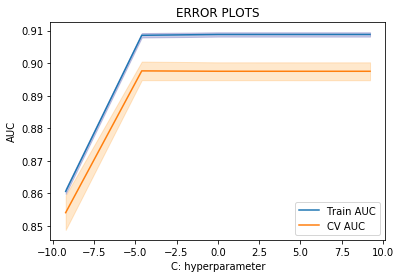

In [79]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
C = [10**-4, 10**-2, 10**0, 10**2, 10**4]
for i in C:

    lr = LogisticRegression(penalty='l2', C = i)
    tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
    clf = GridSearchCV(lr, tuned_parameters, cv=5, scoring='roc_auc')
    clf.fit(X_train_bow_standardized, Y_train)
    

    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(np.log(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Testing with Test data

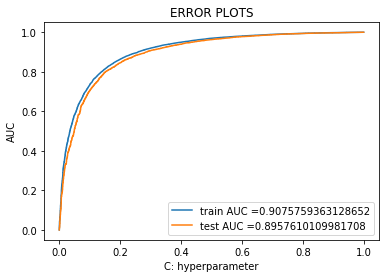

Train confusion matrix
[[ 4237  4415]
 [ 1303 43645]]
Test confusion matrix
[[ 1489  1679]
 [  547 16285]]
Test AUC is: 0.8957610109981708


In [80]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


lr = LogisticRegression(C=0.01) # Here in plce of n_neighbors=19 we can also take n_neighbors=optimal_k. optimal_k will 
                                           # automatically take value which we have been observed when we have done 
                                           # k-fold cross validation
lr.fit(X_train_bow_standardized, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, lr.predict_proba(X_train_bow_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, lr.predict_proba(X_test_bow_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, lr.predict(X_train_bow_standardized)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, lr.predict(X_test_bow_standardized)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
bow_L2_auc = roc_auc_score(Y_test, lr.predict_proba(X_test_bow_standardized)[:,1])
print("Test AUC is:", bow_L2_auc)

In [81]:
# http://localhost:8888/notebooks/Downloads/kfold.ipynb
# ============================== lr with k = optimal_k ===============================================
# instantiate learning model k = optimal_k

lr_optimal = LogisticRegression(C=optimal_C)

# fitting the model
lr_optimal.fit(X_train_bow_standardized, Y_train)

# predict the response
Y_pred = lr_optimal.predict(X_test_bow_standardized)

# Accuracy on test data
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
bow_L2_grid_C = optimal_C
bow_L2_grid_train_acc = model.score(X_test_bow_standardized, Y_test)*100
bow_L2_grid_test_acc = acc


The Test Accuracy of the Logistic Regression classifier for C = 0.010 is 88.870000%


Observation(s):
    
1. The Test Accuracy of the Logistic Regression classifier for C = 0.010 is 88.710%.

# Confusion Matrix of Training Set Of BOW Model

In [82]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_train, lr.predict(X_train_bow_standardized)))
cm

array([[ 4237,  4415],
       [ 1303, 43645]], dtype=int64)

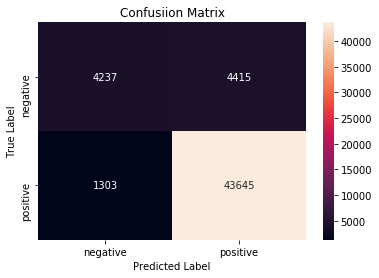

In [83]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Training Set Of BOW Model.
1. As we have seen on confusion matrix, we have 43712 + 4163 = 47875 correct prediction on training set.
2. Acccuracy of 47875 correct prediction on training set is 89.319%.

# Confusion Matrix For Test Set Of BOW Model

In [84]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_test, lr.predict(X_test_bow_standardized)))
cm

array([[ 1489,  1679],
       [  547, 16285]], dtype=int64)

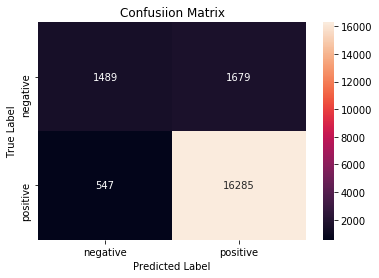

In [85]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Test Set Of BOW Model.
2. As we have seen on confusion matrix, we have 16201 + 1541 = 17742 correct prediction on test set.
2. Acccuracy of 17742 correct prediction on test set is 88.71%.

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [86]:
# https://stats.stackexchange.com/questions/69959/test-multicollinearity-for-multinomial-logit-regression
# https://statinfer.com/204-2-5-multicollinearity-and-individual-impact-of-variables-in-logistic-regression/
# https://www.kaggle.com/robertoruiz/dealing-with-multicollinearity
lr = LogisticRegression(penalty='l2', C = 0.01)
lr.fit(X_train_bow_standardized,Y_train)
W = lr.coef_ # weight vector  # Getting the weights W after fitting my model with the data X i.e Train data.

# Getting new data set by addind a small noise
X_new = X_train_bow_standardized.astype(float)
X_new.data += np.random.uniform(0.00000001,0.0001,1) # Adding a noise to the X (X' = X + e) and get the new data set X' 
                                                       # (As X is a sparse matrix, X.data+=e)
# Here we are taking 3 positional arguments otherwise it gives "TypeError: uniform() takes at most 3 positional arguments"

# Fitting the model again on new data
lr = LogisticRegression(penalty='l2', C = 0.01)
lr.fit(X_new,Y_train)
W_new = lr.coef_ # Fit the model again on data X' and get the weights W'

# Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e W=W+10^-6 and W’ = W’+10^-6
# Adding small esilon to weight vector to avoid division by 0
W += 10**-6
W_new += 10**-6

# Now find the % change between W and W' (| (W-W') / (W) |)*100)
percentage_change_vector = abs( (W-W_new) / (W) )*100

In [87]:
t = range(0,101,10)       # Calculating the 0th, 10th, 20th, 30th, ...100th percentiles, 
                          # and observing any sudden rise in the values of percentage_change_vector
for i in t:
    print(i, "th percentile : ",np.percentile(percentage_change_vector,i))

0 th percentile :  4.907688204424792e-06
10 th percentile :  0.0001335016163728329
20 th percentile :  0.00021886057828667752
30 th percentile :  0.0002636825643059449
40 th percentile :  0.000305474522317013
50 th percentile :  0.00034506166474555105
60 th percentile :  0.00038693609575684256
70 th percentile :  0.00046334035041142104
80 th percentile :  0.0005575577412644707
90 th percentile :  0.000857215426508665
100 th percentile :  0.0571692852522349


Observation(s):

1. As we have seen there is a sudden rise in the values of percentage_change_vector.
2. Our 0 th percentile is 6.511 and 10 th percentile are 0.0002, so there is sudden rise from 6.511 to 0.0002.
3. now calculate the 0 th to 10th percentile.

In [88]:
t = range(0,11,1)  # Calculating the 0th, 1st, 2nd, 3rd, ...10th percentiles, 
                          # and observing any sudden rise in the values of percentage_change_vector
for i in t:
    print(i, "th percentile : ",np.percentile(percentage_change_vector,i))

0 th percentile :  4.907688204424792e-06
1 th percentile :  1.5092222545752042e-05
2 th percentile :  4.599438120758716e-05
3 th percentile :  6.47943756887962e-05
4 th percentile :  7.076300664844537e-05
5 th percentile :  8.110376426751853e-05
6 th percentile :  9.87198949726352e-05
7 th percentile :  0.00010313943006381928
8 th percentile :  0.0001113906680328776
9 th percentile :  0.00012483350073933073
10 th percentile :  0.0001335016163728329


Observation(s):

1. As we have seen there is a sudden rise in the values of percentage_change_vector.
2. Our 3 rd percentile is 8.16 and 4 th percentile are 0.0001214, so there is sudden rise from 8.16 to 0.0001214.
3. now calculate the 3.1, 3.2, 3.3,..., 4 th percentile values and get the proper value after which there is sudden rise the values.

In [89]:
t = np.linspace(3,4,10) # now calculate the 0.0, 0.1, 0.2, 0.3,..., 1st percentile values 
                    # and get the proper value after which there is sudden rise the values
for i in t:
    print(i, "th percentile : ",np.percentile(percentage_change_vector,i))

3.0 th percentile :  6.47943756887962e-05
3.111111111111111 th percentile :  6.620484701295366e-05
3.2222222222222223 th percentile :  6.724088277761391e-05
3.3333333333333335 th percentile :  6.72820384739488e-05
3.4444444444444446 th percentile :  6.753146737058638e-05
3.5555555555555554 th percentile :  6.818758358142443e-05
3.6666666666666665 th percentile :  6.88185807174533e-05
3.7777777777777777 th percentile :  6.942775154128837e-05
3.888888888888889 th percentile :  7.008631288909649e-05
4.0 th percentile :  7.076300664844537e-05


Observation(s):

1. As we have seen there is a sudden rise in the values of percentage_change_vector.
2. Our 3.5 st percentile is 9.879 and 3.6 nd percentile are 0.000103, so there is sudden rise from 9.879 to 0.000103.
3. so proper value after which there is sudden rise the values is 9.879.

In [90]:
difference = (abs(W - W_new)/W) * 100
threshold = difference[np.where(difference > 9.87)].size
print("Percentage of features which did not change by more than 9.87% is :",(W.size - threshold)/W.size*100)

# Print the feature names whose % change is more than a threshold x,
# after which there is sudden rise the values(in our example it's 9.87)
print("No. of features have weight changes greater than 9.87% is :",difference[np.where(difference > 9.87)].size)

Percentage of features which did not change by more than 9.87% is : 100.0
No. of features have weight changes greater than 9.87% is : 0


Observation(s):

1. Multicollinearity refers to a situation in which two or more explanatory features in regression model are highly linearly related.
2. AS Percentage of features which did not change by more than 9.87% is : 100.0, So we can say that there is no multicollinearity
3. As they are not related to each other.

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [91]:
# Now we can find log probabilities of different features for 'positive' classes
class_features = lr_optimal.coef_   # https://stackoverflow.com/questions/29867367/sklearn-multinomial-nb-most-informative-features
                                               # coef_ value is proportional to feature_log_prob_
                                               # It is like feature importance. This will give us festure importance
# row_0 is for 'positive' class
positive_features = class_features[0]

# Getting all feature names
feature_names = count_vect.get_feature_names()

# Sorting 'positive_features' in descending order using argsort() function
sorted_positive_features = np.argsort(positive_features)[::-1]
    
print("\n\nTop 10 Important Features and their log probabilities For Positive Class :\n\n")
for i in list(sorted_positive_features[0:10]):
    print("%s\t -->\t%f  "%(feature_names[i],positive_features[i]))



Top 10 Important Features and their log probabilities For Positive Class :


great	 -->	0.607775  
delicious	 -->	0.431887  
best	 -->	0.426403  
perfect	 -->	0.391003  
excellent	 -->	0.362096  
love	 -->	0.348869  
loves	 -->	0.348209  
good	 -->	0.344320  
awesome	 -->	0.284824  
wonderful	 -->	0.271815  


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [92]:
# Now we can find log probabilities of different features for 'negative' classes
class_features = lr_optimal.coef_     # https://stackoverflow.com/questions/29867367/sklearn-multinomial-nb-most-informative-features
                                               # coef_ value is proportional to feature_log_prob_
                                               # It is like feature importance. This will give us festure importance
#  row_0 is for 'negative' class
negative_features = class_features[0]

# Getting all feature names
feature_names = count_vect.get_feature_names()

# Sorting 'negative_features' in descending order using argsort() function
sorted_negative_features = np.argsort(negative_features)[::-1]

print("Top 10 Important Features and their log probabilities For Negative Class :\n\n")
for i in list(sorted_negative_features[:-10:-1]):
    print("%s\t -->\t%f  "%(feature_names[i],negative_features[i]))


Top 10 Important Features and their log probabilities For Negative Class :


not	 -->	-0.577709  
disappointed	 -->	-0.250526  
money	 -->	-0.229367  
bad	 -->	-0.174446  
product	 -->	-0.169699  
thought	 -->	-0.160265  
away	 -->	-0.156105  
taste	 -->	-0.140765  
something	 -->	-0.124911  


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

In [93]:
# Data-preprocessing: Standardizing the data
sc = StandardScaler(with_mean=False)
X_train_tf_idf_standardized = sc.fit_transform(X_train_tf_idf)
X_cv_tf_idf_standardized = sc.fit_transform(X_cv_tf_idf)
X_test_tf_idf_standardized = sc.transform(X_test_tf_idf)

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

# GridSearchCV Implementation

In [94]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

#refer: http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer

tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'roc_auc', cv=3 ,n_jobs=-1, 
                     pre_dispatch=2)
model.fit(X_cv_tf_idf_standardized, Y_cv)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_cv_tf_idf_standardized, Y_cv))


optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)


Model with best parameters :
 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.92482454301355
The optimal value of C(1/lambda) is :  1


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter

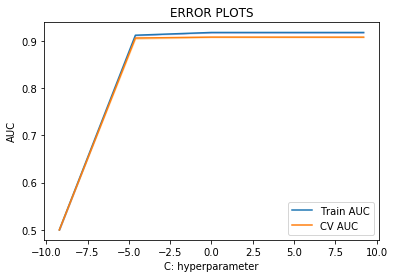

In [95]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
C = [10**-4, 10**-2, 10**0, 10**2, 10**4]
for i in C:

    lr = LogisticRegression(penalty='l1', C = i)
    tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
    clf = GridSearchCV(lr, tuned_parameters, cv=3, scoring='roc_auc')
    clf.fit(X_train_tf_idf_standardized, Y_train)
    

    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(np.log(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Testing with Test data

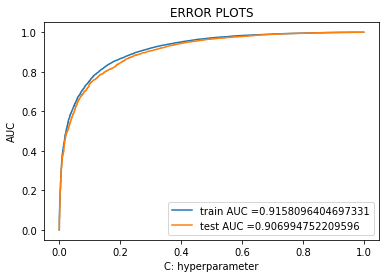

Train confusion matrix
[[ 4664  3988]
 [ 1576 43372]]
Test confusion matrix
[[ 1639  1529]
 [  617 16215]]
Test AUC is: 0.906994752209596


In [96]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


lr = LogisticRegression(C=1) # Here in plce of n_neighbors=19 we can also take n_neighbors=optimal_k. optimal_k will 
                                           # automatically take value which we have been observed when we have done 
                                           # k-fold cross validation
lr.fit(X_train_tf_idf_standardized, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, lr.predict_proba(X_train_tf_idf_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, lr.predict_proba(X_test_tf_idf_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, lr.predict(X_train_tf_idf_standardized)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, lr.predict(X_test_tf_idf_standardized)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
tfidf_L1_auc = roc_auc_score(Y_test, lr.predict_proba(X_test_tf_idf_standardized)[:,1])
print("Test AUC is:", tfidf_L1_auc)

In [97]:
# http://localhost:8888/notebooks/Downloads/kfold.ipynb
# ============================== lr with k = optimal_k ===============================================
# instantiate learning model k = optimal_k

lr_optimal = LogisticRegression(C=optimal_C)

# fitting the model
lr_optimal.fit(X_train_tf_idf_standardized, Y_train)

# predict the response
Y_pred = lr_optimal.predict(X_test_tf_idf_standardized)

# Accuracy on test data
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_L1_grid_C = optimal_C
tfidf_L1_grid_train_acc = model.score(X_test_tf_idf_standardized, Y_test)*100
tfidf_L1_grid_test_acc = accuracy_score(Y_test, Y_pred) * 100


The Test Accuracy of the Logistic Regression classifier for C = 1.000 is 89.270000%


Observation(s):

1. The Test Accuracy of the Logistic Regression classifier for C = 1.000 is 89.130.

# Confusion Matrix of Training Set Of TFIDF Model

In [98]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_train, lr.predict(X_train_bow)))
cm

array([[   10,  8642],
       [   14, 44934]], dtype=int64)

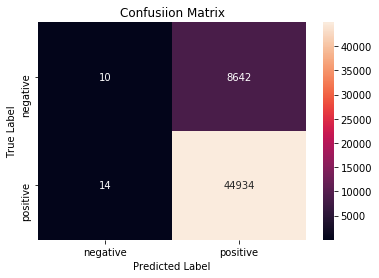

In [99]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Training Set Of TFIDF Model.
1. As we have seen on confusion matrix, we have 45010 + 36 = 45046 correct prediction on training set.
2. Acccuracy of 45046 correct prediction on training set is 84.041%.

# Confusion Matrix of Test Set Of TFIDF Model

In [100]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_test, lr.predict(X_test_bow)))
cm

array([[    3,  3165],
       [    6, 16826]], dtype=int64)

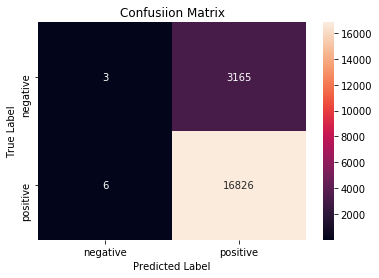

In [101]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Test Set Of TFIDF Model.
2. As we have seen on confusion matrix, we have 16732 + 14 = 16746 correct prediction on test set.
2. Acccuracy of 16746 correct prediction on test set is 83.73%.

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [102]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

#refer: http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer

tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'roc_auc', cv=5, n_jobs=-1, 
                     pre_dispatch=2)
model.fit(X_cv_tf_idf_standardized, Y_cv)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_cv_tf_idf_standardized, Y_cv))


optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

Model with best parameters :
 LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.9245546807147874
The optimal value of C(1/lambda) is :  0.01


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter

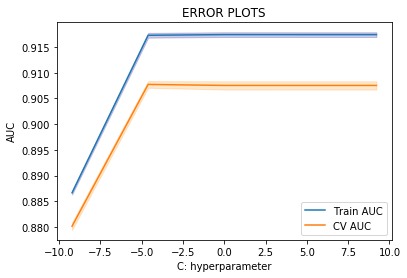

In [103]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
C = [10**-4, 10**-2, 10**0, 10**2, 10**4]
for i in C:

    lr = LogisticRegression(penalty='l2', C = i)
    tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
    clf = GridSearchCV(lr, tuned_parameters, cv=3, scoring='roc_auc')
    clf.fit(X_train_tf_idf_standardized, Y_train)
    

    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(np.log(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Testing with Test data

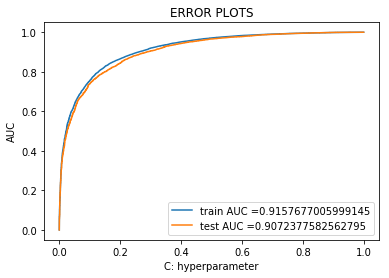

Train confusion matrix
[[ 4593  4059]
 [ 1532 43416]]
Test confusion matrix
[[ 1610  1558]
 [  598 16234]]
Test AUC is: 0.9072377582562795


In [104]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


lr = LogisticRegression(C=0.01) # Here in plce of n_neighbors=19 we can also take n_neighbors=optimal_k. optimal_k will 
                                           # automatically take value which we have been observed when we have done 
                                           # k-fold cross validation
lr.fit(X_train_tf_idf_standardized, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, lr.predict_proba(X_train_tf_idf_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, lr.predict_proba(X_test_tf_idf_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, lr.predict(X_train_tf_idf_standardized)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, lr.predict(X_test_tf_idf_standardized)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
tfidf_L2_auc = roc_auc_score(Y_test, lr.predict_proba(X_test_tf_idf_standardized)[:,1])
print("Test AUC is:", tfidf_L2_auc)

In [105]:
# http://localhost:8888/notebooks/Downloads/kfold.ipynb
# ============================== lr with k = optimal_k ===============================================
# instantiate learning model k = optimal_k

lr_optimal = LogisticRegression(C=optimal_C)

# fitting the model
lr_optimal.fit(X_train_tf_idf_standardized, Y_train)

# predict the response
Y_pred = lr_optimal.predict(X_test_tf_idf_standardized)

# Accuracy on test data
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_L2_grid_C = optimal_C
tfidf_L2_grid_train_acc = model.score(X_test_tf_idf_standardized, Y_test)*100
tfidf_L2_grid_test_acc = accuracy_score(Y_test, Y_pred) * 100


The Test Accuracy of the Logistic Regression classifier for C = 0.010 is 89.220000%


Observation(s):

1. The Test Accuracy of the Logistic Regression classifier for C = 0.010 is 89.070%.

# Confusion Matrix of Training Set Of TFIDF Model

In [106]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_train, lr.predict(X_train_bow)))
cm

array([[   13,  8639],
       [   19, 44929]], dtype=int64)

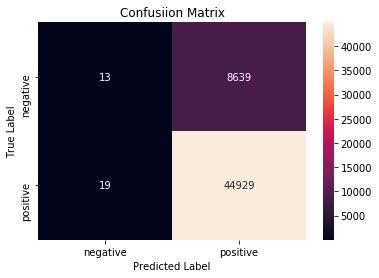

In [107]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Training Set Of TFIDF Model.
1. As we have seen on confusion matrix, we have 45004 + 54 = 45508 correct prediction on training set.
2. Acccuracy of 45508 correct prediction on training set is 84.063%.

# Confusion Matrix For Test Set Of TFIDF Model

In [108]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_test, lr.predict(X_test_bow)))
cm

array([[    5,  3163],
       [    8, 16824]], dtype=int64)

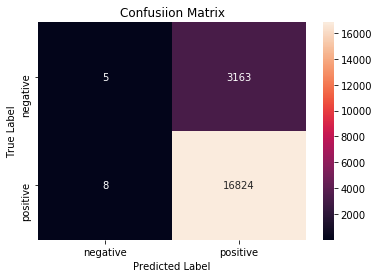

In [109]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Test Set Of TFIDF Model.
2. As we have seen on confusion matrix, we have 16726 + 19 = 16745 correct prediction on test set.
2. Acccuracy of 16745 correct prediction on test set is 83.725%.

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [110]:
# Now we can find log probabilities of different features for 'positive' classes
class_features = lr_optimal.coef_   # https://stackoverflow.com/questions/29867367/sklearn-multinomial-nb-most-informative-features
                                               # coef_ value is proportional to feature_log_prob_
                                               # It is like feature importance. This will give us festure importance
# row_0 is for 'positive' class
positive_features = class_features[0]

# Getting all feature names
feature_names = count_vect.get_feature_names()

# Sorting 'positive_features' in descending order using argsort() function
sorted_positive_features = np.argsort(positive_features)[::-1]
    
print("\n\nTop 10 Important Features and their log probabilities For Positive Class :\n\n")
for i in list(sorted_positive_features[0:10]):
    print("%s\t -->\t%f  "%(feature_names[i],positive_features[i]))



Top 10 Important Features and their log probabilities For Positive Class :


grocery	 -->	0.695215  
big	 -->	0.479382  
definitely	 -->	0.467545  
pet	 -->	0.399529  
great	 -->	0.393430  
making	 -->	0.390102  
exactly	 -->	0.382252  
market	 -->	0.382069  
work	 -->	0.319226  
not know	 -->	0.288604  


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [111]:
# Now we can find log probabilities of different features for 'negative' classes
class_features = lr_optimal.coef_     # https://stackoverflow.com/questions/29867367/sklearn-multinomial-nb-most-informative-features
                                               # coef_ value is proportional to feature_log_prob_
                                               # It is like feature importance. This will give us festure importance
#  row_0 is for 'negative' class
negative_features = class_features[0]

# Getting all feature names
feature_names = count_vect.get_feature_names()

# Sorting 'negative_features' in descending order using argsort() function
sorted_negative_features = np.argsort(negative_features)[::-1]

print("Top 10 Important Features and their log probabilities For Negative Class :\n\n")
for i in list(sorted_negative_features[:-10:-1]):
    print("%s\t -->\t%f  "%(feature_names[i],negative_features[i]))

Top 10 Important Features and their log probabilities For Negative Class :


nuts	 -->	-0.463763  
disappointed	 -->	-0.240247  
natural	 -->	-0.208648  
tasted	 -->	-0.161305  
baby	 -->	-0.159499  
bags	 -->	-0.152018  
products	 -->	-0.149420  
etc	 -->	-0.142176  
thought	 -->	-0.134841  


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [112]:
# Data-preprocessing: Standardizing the data
sc = StandardScaler(with_mean=False)
sent_vectors_train_standardized = sc.fit_transform(sent_vectors_train)
sent_vectors_cv_standardized = sc.fit_transform(sent_vectors_cv)
sent_vectors_test_standardized = sc.transform(sent_vectors_test)

In [113]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

#refer: http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer

tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'roc_auc', cv=5 ,n_jobs=-1, 
                     pre_dispatch=2)
model.fit(sent_vectors_cv_standardized, Y_cv)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(sent_vectors_cv_standardized, Y_cv))


optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

Model with best parameters :
 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.90679679142021
The optimal value of C(1/lambda) is :  1


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter

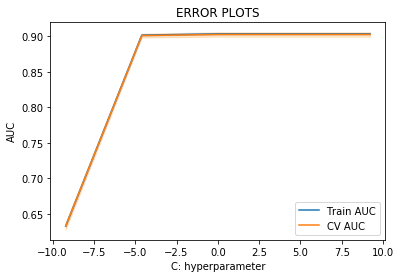

In [114]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
C = [10**-4, 10**-2, 10**0, 10**2, 10**4]
for i in C:

    lr = LogisticRegression(penalty='l1', C = i)
    tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
    clf = GridSearchCV(lr, tuned_parameters, cv=5, scoring='roc_auc')
    clf.fit(sent_vectors_train_standardized, Y_train)
    

    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(np.log(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Testing with Test data

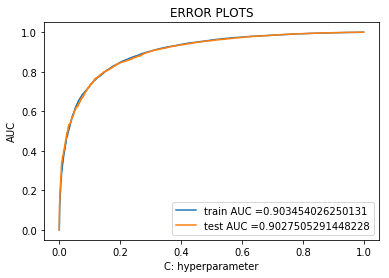

Train confusion matrix
[[ 4086  4566]
 [ 1561 43387]]
Test confusion matrix
[[ 1502  1666]
 [  633 16199]]
Test AUC is: 0.9027505291448228


In [115]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


lr = LogisticRegression(C=100) # Here in plce of n_neighbors=19 we can also take n_neighbors=optimal_k. optimal_k will 
                                           # automatically take value which we have been observed when we have done 
                                           # k-fold cross validation
lr.fit(sent_vectors_train_standardized, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, lr.predict_proba(sent_vectors_train_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, lr.predict_proba(sent_vectors_test_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, lr.predict(sent_vectors_train_standardized)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, lr.predict(sent_vectors_test_standardized)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
avg_w2v_L1_auc = roc_auc_score(Y_test, lr.predict_proba(sent_vectors_test_standardized)[:,1])
print("Test AUC is:", avg_w2v_L1_auc)

In [116]:
# http://localhost:8888/notebooks/Downloads/kfold.ipynb
# ============================== lr with k = optimal_k ===============================================
# instantiate learning model k = optimal_k

lr_optimal = LogisticRegression(C=optimal_C)

# fitting the model
lr_optimal.fit(sent_vectors_train_standardized, Y_train)

# predict the response
Y_pred = lr_optimal.predict(sent_vectors_test_standardized)

# Accuracy on test data
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
avg_w2v_L1_grid_C = optimal_C
avg_w2v_L1_grid_train_acc = model.score(sent_vectors_test_standardized, Y_test)*100
avg_w2v_L1_grid_test_acc = accuracy_score(Y_test, Y_pred) * 100


The Test Accuracy of the Logistic Regression classifier for C = 1.000 is 88.500000%


Observation(s):

1. The Test Accuracy of the Logistic Regression classifier for C = 100.000 is 88.125%.

# Confusion Matrix of Training Set Of w2v Model

In [117]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_train, lr.predict(sent_vectors_train_standardized))
cm

array([[ 4086,  4566],
       [ 1561, 43387]], dtype=int64)

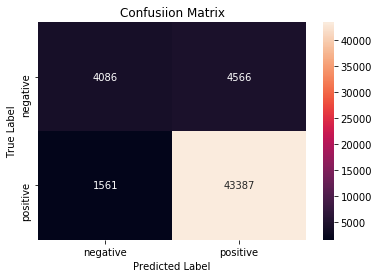

In [118]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Training Set Of AVG W2V Model.
1. As we have seen on confusion matrix, we have 43511 + 3987 = 47498 correct prediction on training set.
2. Acccuracy of 47498 correct prediction on training set is 88.615%.

# Confusion Matrix For Test Set Of BOW Model

In [119]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, lr.predict(sent_vectors_test_standardized))
cm

array([[ 1502,  1666],
       [  633, 16199]], dtype=int64)

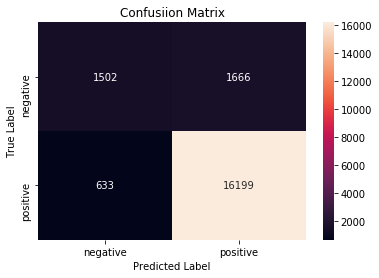

In [120]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Test Set Of AVG W2V Model.
2. As we have seen on confusion matrix, we have 16137 + 1488 = 17625 correct prediction on test set.
2. Acccuracy of 17625 correct prediction on test set is 88.125%.

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [121]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

#refer: http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer

tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'roc_auc', cv=5 ,n_jobs=-1, 
                     pre_dispatch=2)
model.fit(sent_vectors_cv_standardized, Y_cv)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(sent_vectors_cv_standardized, Y_cv))


optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

Model with best parameters :
 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.9067919774793433
The optimal value of C(1/lambda) is :  1


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter

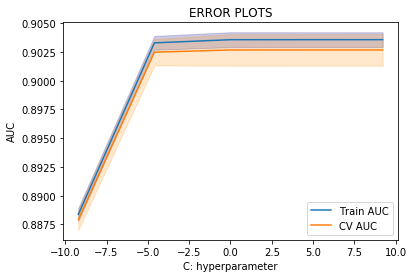

In [122]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
C = [10**-4, 10**-2, 10**0, 10**2, 10**4]
for i in C:

    lr = LogisticRegression(penalty='l2', C = i)
    tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
    clf = GridSearchCV(lr, tuned_parameters, cv=3, scoring='roc_auc')
    clf.fit(sent_vectors_train_standardized, Y_train)
    

    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(np.log(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Testing with Test data

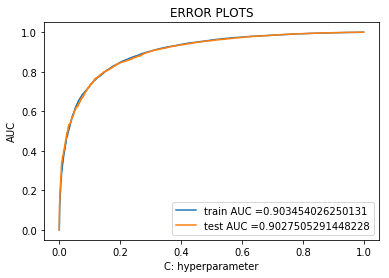

Train confusion matrix
[[ 4086  4566]
 [ 1561 43387]]
Test confusion matrix
[[ 1502  1666]
 [  633 16199]]
Test AUC is: 0.9027505291448228


In [123]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


lr = LogisticRegression(C=100) # Here in plce of n_neighbors=19 we can also take n_neighbors=optimal_k. optimal_k will 
                                           # automatically take value which we have been observed when we have done 
                                           # k-fold cross validation
lr.fit(sent_vectors_train_standardized, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, lr.predict_proba(sent_vectors_train_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, lr.predict_proba(sent_vectors_test_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, lr.predict(sent_vectors_train_standardized)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, lr.predict(sent_vectors_test_standardized)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
avg_w2v_L2_auc = roc_auc_score(Y_test, lr.predict_proba(sent_vectors_test_standardized)[:,1])
print("Test AUC is:", avg_w2v_L2_auc)

In [124]:
# http://localhost:8888/notebooks/Downloads/kfold.ipynb
# ============================== lr with k = optimal_k ===============================================
# instantiate learning model k = optimal_k

lr_optimal = LogisticRegression(C=optimal_C)

# fitting the model
lr_optimal.fit(sent_vectors_train_standardized, Y_train)

# predict the response
Y_pred = lr_optimal.predict(sent_vectors_test_standardized)

# Accuracy on test data
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
avg_w2v_L2_grid_C = optimal_C
avg_w2v_L2_grid_train_acc = model.score(sent_vectors_test_standardized, Y_test)*100
avg_w2v_L2_grid_test_acc = accuracy_score(Y_test, Y_pred) * 100


The Test Accuracy of the Logistic Regression classifier for C = 1.000 is 88.500000%


Observation(s):

1. The Test Accuracy of the Logistic Regression classifier for C = 100.000 is 88.125%.

# Confusion Matrix of Training Set Of W2V Model

In [125]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_train, lr.predict(sent_vectors_train_standardized))
cm

array([[ 4086,  4566],
       [ 1561, 43387]], dtype=int64)

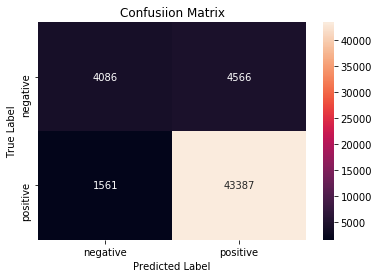

In [126]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Training Set Of AVG W2V Model.
1. As we have seen on confusion matrix, we have 43511 + 3987 = 47498 correct prediction on training set.
2. Acccuracy of 47498 correct prediction on training set is 88.615%.

# Confusion Matrix For Test Set Of W2V Model

In [127]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_test, lr.predict(sent_vectors_test_standardized)))
cm

array([[ 1502,  1666],
       [  633, 16199]], dtype=int64)

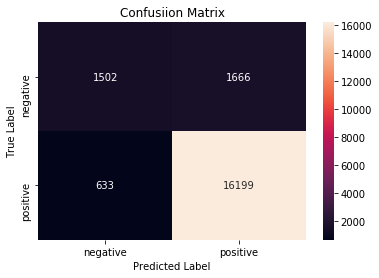

In [128]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Test Set Of AVG W2V Model.
2. As we have seen on confusion matrix, we have 16137 + 1488 = 17625 correct prediction on test set.
2. Acccuracy of 17625 correct prediction on test set is 88.125.

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

In [129]:
# Data-preprocessing: Standardizing the data
sc = StandardScaler(with_mean=False)
tfidf_sent_vectors_train_standardized = sc.fit_transform(tfidf_sent_vectors_train)
tfidf_sent_vectors_cv_standardized = sc.fit_transform(tfidf_sent_vectors_cv)
tfidf_sent_vectors_test_standardized = sc.transform(tfidf_sent_vectors_test)

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [130]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

#refer: http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer

tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'roc_auc', cv=5 ,n_jobs=-1, 
                     pre_dispatch=2)
model.fit(tfidf_sent_vectors_cv_standardized, Y_cv)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(tfidf_sent_vectors_cv_standardized, Y_cv))


optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

Model with best parameters :
 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.8823003678913501
The optimal value of C(1/lambda) is :  1


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter

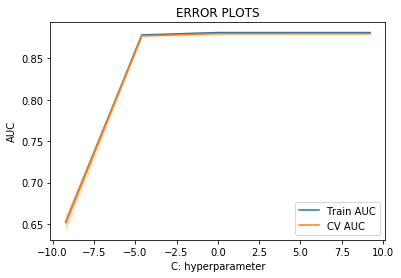

In [131]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
C = [10**-4, 10**-2, 10**0, 10**2, 10**4]
for i in C:

    lr = LogisticRegression(penalty='l1', C = i)
    tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
    clf = GridSearchCV(lr, tuned_parameters, cv=3, scoring='roc_auc')
    clf.fit(tfidf_sent_vectors_train_standardized, Y_train)
    

    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(np.log(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Testing with Test data

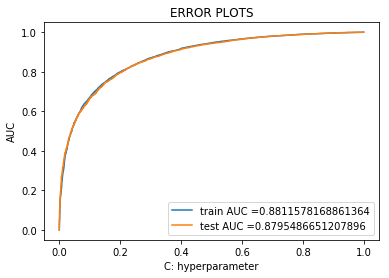

Train confusion matrix
[[ 3416  5236]
 [ 1487 43461]]
Test confusion matrix
[[ 1251  1917]
 [  572 16260]]
Test AUC is: 0.8795486651207896


In [132]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


lr = LogisticRegression(C=1) # Here in plce of n_neighbors=19 we can also take n_neighbors=optimal_k. optimal_k will 
                                           # automatically take value which we have been observed when we have done 
                                           # k-fold cross validation
lr.fit(tfidf_sent_vectors_train_standardized, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, lr.predict_proba(tfidf_sent_vectors_train_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, lr.predict_proba(tfidf_sent_vectors_test_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, lr.predict(tfidf_sent_vectors_train_standardized)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, lr.predict(tfidf_sent_vectors_test_standardized)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
tfidf_w2v_L1_auc = roc_auc_score(Y_test, lr.predict_proba(tfidf_sent_vectors_test_standardized)[:,1])
print("Test AUC is:", tfidf_w2v_L1_auc)

In [133]:
# http://localhost:8888/notebooks/Downloads/kfold.ipynb
# ============================== lr with k = optimal_k ===============================================
# instantiate learning model k = optimal_k

lr_optimal = LogisticRegression(C=optimal_C)

# fitting the model
lr_optimal.fit(tfidf_sent_vectors_train_standardized, Y_train)

# predict the response
Y_pred = lr_optimal.predict(tfidf_sent_vectors_test_standardized)

# Accuracy on test data
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_w2v_L1_grid_C = optimal_C
tfidf_w2v_L1_grid_train_acc = model.score(tfidf_sent_vectors_test_standardized, Y_test)*100
tfidf_w2v_L1_grid_test_acc = accuracy_score(Y_test, Y_pred) * 100


The Test Accuracy of the Logistic Regression classifier for C = 1.000 is 87.555000%


Observation(s):

1. The Test Accuracy of the Logistic Regression classifier for C = 1.000 is 86.785%.

# Confusion Matrix of Training Set Of TFIDF W2V Model

In [134]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_train, lr.predict(tfidf_sent_vectors_train_standardized))
cm

array([[ 3416,  5236],
       [ 1487, 43461]], dtype=int64)

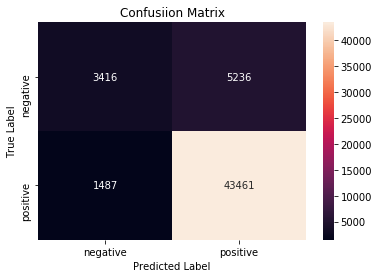

In [135]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Training Set Of TFIDF W2V Model.
1. As we have seen on confusion matrix, we have 43597 + 3257 = 46854 correct prediction on training set.
2. Acccuracy of 46854 correct prediction on training set is 87.414%.

# Confusion Matrix For Test Set Of TFIDF W2V Model

In [136]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, lr.predict(tfidf_sent_vectors_test_standardized))
cm

array([[ 1251,  1917],
       [  572, 16260]], dtype=int64)

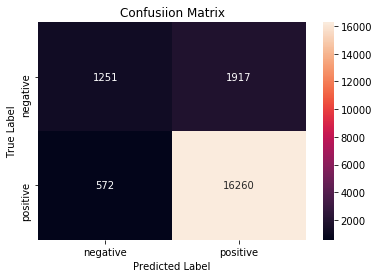

In [137]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Test Set Of TFIDF W2V Model.
2. As we have seen on confusion matrix, we have 16151 + 1206 = 17357 correct prediction on test set.
2. Acccuracy of 17357 correct prediction on test set is 86.785%.

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [138]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

#refer: http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer

tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'roc_auc', cv=5 ,n_jobs=-1, 
                     pre_dispatch=2)
model.fit(tfidf_sent_vectors_cv_standardized, Y_cv)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(tfidf_sent_vectors_cv_standardized, Y_cv))


optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

Model with best parameters :
 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.8823006335613759
The optimal value of C(1/lambda) is :  1


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter

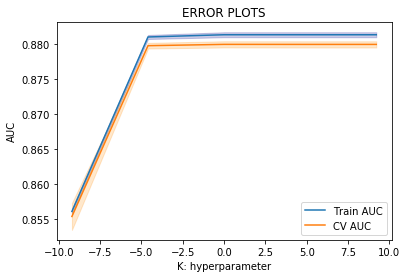

In [139]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
C = [10**-4, 10**-2, 10**0, 10**2, 10**4]
for i in C:

    lr = LogisticRegression(penalty='l2', C = i)
    tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
    clf = GridSearchCV(lr, tuned_parameters, cv=3, scoring='roc_auc')
    clf.fit(tfidf_sent_vectors_train_standardized, Y_train)
    

    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(np.log(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Testing with Test data

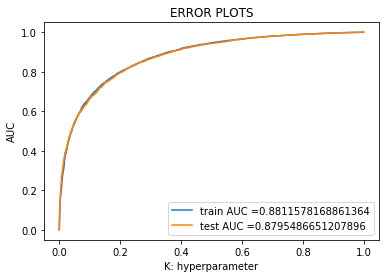

Train confusion matrix
[[ 3416  5236]
 [ 1487 43461]]
Test confusion matrix
[[ 1251  1917]
 [  572 16260]]
Test AUC is: 0.8795486651207896


In [140]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


lr = LogisticRegression(C=1) # Here in plce of n_neighbors=19 we can also take n_neighbors=optimal_k. optimal_k will 
                                           # automatically take value which we have been observed when we have done 
                                           # k-fold cross validation
lr.fit(tfidf_sent_vectors_train_standardized, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, lr.predict_proba(tfidf_sent_vectors_train_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, lr.predict_proba(tfidf_sent_vectors_test_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, lr.predict(tfidf_sent_vectors_train_standardized)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, lr.predict(tfidf_sent_vectors_test_standardized)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
tfidf_w2v_L2_auc = roc_auc_score(Y_test, lr.predict_proba(tfidf_sent_vectors_test_standardized)[:,1])
print("Test AUC is:", tfidf_w2v_L2_auc)

In [141]:
# http://localhost:8888/notebooks/Downloads/kfold.ipynb
# ============================== lr with k = optimal_k ===============================================
# instantiate learning model k = optimal_k

lr_optimal = LogisticRegression(C=optimal_C)

# fitting the model
lr_optimal.fit(tfidf_sent_vectors_train_standardized, Y_train)

# predict the response
Y_pred = lr_optimal.predict(tfidf_sent_vectors_test_standardized)

# Accuracy on test data
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_w2v_L2_grid_C = optimal_C
tfidf_w2v_L2_grid_train_acc = model.score(tfidf_sent_vectors_test_standardized, Y_test)*100
tfidf_w2v_L2_grid_test_acc = accuracy_score(Y_test, Y_pred) * 100


The Test Accuracy of the Logistic Regression classifier for C = 1.000 is 87.555000%


Observation(s):

1. The Test Accuracy of the Logistic Regression classifier for C = 1.000 is 86.785%.

# Confusion Matrix of Training Set Of TFIDF W2V Model

In [142]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_train, lr.predict(tfidf_sent_vectors_train_standardized))
cm

array([[ 3416,  5236],
       [ 1487, 43461]], dtype=int64)

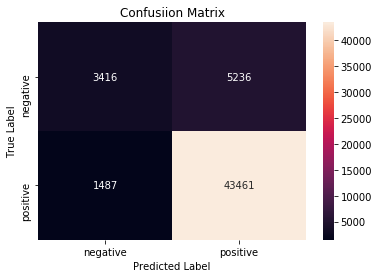

In [143]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Training Set Of TFIDF W2V Model.
1. As we have seen on confusion matrix, we have 43597 + 3257 = 46854 correct prediction on training set.
2. Acccuracy of 46854 correct prediction on training set is 87.414%.

# Confusion Matrix For Test Set Of TFIDF W2V Model

In [144]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, lr.predict(tfidf_sent_vectors_test_standardized))
cm

array([[ 1251,  1917],
       [  572, 16260]], dtype=int64)

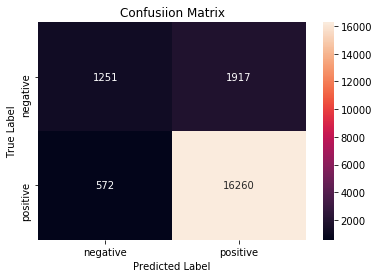

In [145]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Test Set Of TFIDF W2V Model.
2. As we have seen on confusion matrix, we have 16151 + 1206 = 17357 correct prediction on test set.
2. Acccuracy of 17357 correct prediction on test set is 86.785%.

# [6] Conclusions

In [146]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

# Names of models
names = ['L1 Regularization GridSearchCV for BoW','L2 Regularization GridSearchCV for BoW', \
         'L1 Regularization GridSearchCV for TFIDF','L2 Regularization GridSearchCV for TFIDF', \
         'L1 Regularization GridSearchCV for Avg_Word2Vec','L2 Regularization GridSearchCV for Avg_Word2Vec', \
         'L1 Regularization GridSearchCV for TFIDF_Word2Vec','L2 Regularization GridSearchCV for TFIDF_Word2Vec']

# Optimal values of C i.e. (1/lambda)
optimal_C = [bow_L1_grid_C, bow_L2_grid_C, tfidf_L1_grid_C, tfidf_L2_grid_C, \
             avg_w2v_L1_grid_C, avg_w2v_L2_grid_C, tfidf_w2v_L1_grid_C, tfidf_w2v_L2_grid_C]

AUC = [bow_L1_auc, bow_L2_auc, tfidf_L1_auc, tfidf_L2_auc, avg_w2v_L1_auc, \
       avg_w2v_L2_auc, tfidf_w2v_L1_auc, tfidf_w2v_L2_auc]

test_acc = [bow_L1_grid_test_acc, bow_L2_grid_test_acc, tfidf_L1_grid_test_acc, tfidf_L2_grid_test_acc, \
            avg_w2v_L1_grid_test_acc,avg_w2v_L2_grid_test_acc,tfidf_w2v_L1_grid_test_acc, \
            tfidf_w2v_L1_grid_test_acc]

numbering = [1,2,3,4,5,6,7,8]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Best C(1/lambda)",optimal_C)
ptable.add_column("AUC",AUC)
ptable.add_column("Test Accuracy",test_acc)

# Printing the Table
print(ptable)

+-------+---------------------------------------------------+------------------+--------------------+-------------------+
| S.NO. |                       MODEL                       | Best C(1/lambda) |        AUC         |   Test Accuracy   |
+-------+---------------------------------------------------+------------------+--------------------+-------------------+
|   1   |       L1 Regularization GridSearchCV for BoW      |        1         | 0.8957094017497936 |       88.895      |
|   2   |       L2 Regularization GridSearchCV for BoW      |       0.01       | 0.8957610109981708 |       88.87       |
|   3   |      L1 Regularization GridSearchCV for TFIDF     |        1         | 0.906994752209596  | 89.27000000000001 |
|   4   |      L2 Regularization GridSearchCV for TFIDF     |       0.01       | 0.9072377582562795 |       89.22       |
|   5   |  L1 Regularization GridSearchCV for Avg_Word2Vec  |        1         | 0.9027505291448228 |        88.5       |
|   6   |  L2 Regulariza

# Procedure Followed:

STEP 1 : Loading The Data
    
STEP 2 : Data Cleaning: Deduplication

STEP 3 : Preprocessing Review Text

STEP 4 : Preprocessing Review Summary

STEP 5 : Time-based splitting of whole dataset into X_train, Y_train, X_test, Y_test, X_cv and Y_cv.

STEP 6 : Applying Featurization Technique to convert text into vector.(i.e. BAG OF WORDS Model)

STEP 7 : Standardizing the data

STEP 8 : Applying Logistic Regression on BOW

STEP 9 : Using Logistic regression as an estimator in GridSearchCV in order to find optimal value of C i.e(1/lambda) 
         with both L1 and L2 regularisation

STEP 10 : Plotting the performance of model both on train data and cross validation data for each hyper parameter

STEP 11 : Finding the AUC on test data and plotting the ROC curve on both train and test.

STEP 12 : Drawing the confusion matrix using Seaborn Heatmaps.

STEP 11 : Calculating sparsity on weight vector obtained using L1 regularization on BOW (L1 and L2 regularisation)

STEP 11 : Performing pertubation test (multicollinearity check) on BOW (L1 and L2 regularisation)

STEP 13 : Finding the top 10 features of positive class from Set 1. (Only in Bow and TFIDF Vectorizer)

STEP 14 : Finding top 10 features of negative class from Set 1.(Only in Bow and TFIDF Vectorizer)

STEP 15 : Repeat STEP 6 to STEP 15 for TFIDF, Avg_w2v, TFIDF_w2v Vectorizer.